In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix

import numpy as np
import tensorflow as tf
from tensorflow import keras


2022-11-27 19:36:41.917320: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [3]:
questions_data = pd.read_csv("processed_questions.csv")

In [4]:
questions_data.head(2)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Id,OwnerUserId,CreationDate,Score,Title,Body,highest_answer_score,num_answers,has_positive_answer,Full_Text,Title_Word_Count,Body_Word_Count
0,0,0,0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,12,4,1,How can I find the full path to a font from it...,17,70
1,1,1,1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,9,2,1,Get a preview JPEG of a PDF on Windows? <p>I h...,9,38


In [5]:
x = questions_data['Title']
y = questions_data['has_positive_answer']

In [6]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [7]:
vocab_size = 1000

In [8]:
vect = CountVectorizer(
    stop_words = 'english',
    max_features = vocab_size
)

x_train_cv = vect.fit_transform(X_train).todense()
x_test_cv = vect.transform(X_test).todense()

In [9]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {}
for i in range(0,2):
    class_weights_dict[i] = class_weights[i]
class_weights_dict

{0: 1.518497333858435, 1: 0.7454596508887361}

In [10]:
def build_model(hidden_size):
    input_layer = tf.keras.layers.Input(shape=(vocab_size,), dtype=tf.int64, name='input_layer')
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(input_layer)

    dropout_layer = tf.keras.layers.Dropout(0.03)(hidden)

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(dropout_layer)
    classification_model = tf.keras.Model(inputs=input_layer, outputs=classification)

    classification_model.compile(optimizer='adam',
                                     loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                     metrics='accuracy')
    return classification_model

In [11]:
classification_model = build_model(100)

2022-11-27 19:36:57.099237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-27 19:36:57.128566: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-11-27 19:36:57.128586: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-27 19:36:57.129218: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

In [12]:
model_history = classification_model.fit(
    x_train_cv,
    y_train,
    validation_data=(x_test_cv, y_test),
    batch_size=32,
    epochs=7,
    class_weight=class_weights_dict,
    verbose=True
)  

Epoch 1/7
15183/15183 [==============================] - 38s 2ms/step - loss: 0.6641 - accuracy: 0.5810 - val_loss: 0.6528 - val_accuracy: 0.5935
Epoch 2/7
15183/15183 [==============================] - 33s 2ms/step - loss: 0.6579 - accuracy: 0.5904 - val_loss: 0.6617 - val_accuracy: 0.5884
Epoch 3/7
15183/15183 [==============================] - 36s 2ms/step - loss: 0.6520 - accuracy: 0.6047 - val_loss: 0.6616 - val_accuracy: 0.5919
Epoch 4/7
15183/15183 [==============================] - 33s 2ms/step - loss: 0.6445 - accuracy: 0.6193 - val_loss: 0.6779 - val_accuracy: 0.5772
Epoch 5/7
15183/15183 [==============================] - 39s 3ms/step - loss: 0.6362 - accuracy: 0.6315 - val_loss: 0.6747 - val_accuracy: 0.5884
Epoch 6/7
15183/15183 [==============================] - 30s 2ms/step - loss: 0.6279 - accuracy: 0.6427 - val_loss: 0.6801 - val_accuracy: 0.5855
Epoch 7/7
15183/15183 [==============================] - 30s 2ms/step - loss: 0.6196 - accuracy: 0.6522 - val_loss: 0.6826 -

### Test on the holdout data

In [13]:
y_pred_raw = classification_model.predict(x_test_cv)

3796/3796 [==============================] - 3s 865us/step


In [14]:
# we want the probability of the 1 class
y_pred_raw = [x[0] for x in y_pred_raw]

In [15]:
y_pred = (np.array(y_pred_raw) > 0.5).astype(int)

In [16]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_raw)
auc = metrics.roc_auc_score(y_test, y_pred_raw)

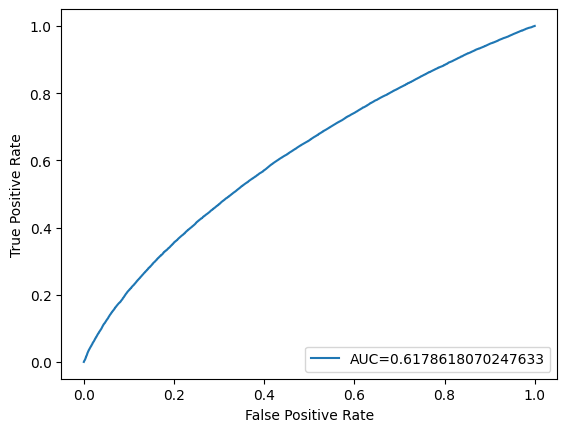

In [17]:
import matplotlib.pyplot as plt

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [18]:
from sklearn.metrics import f1_score, precision_score, recall_score
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [19]:
from sklearn.metrics import f1_score, precision_score, recall_score
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [20]:
print(f"f1 score is: {f1}")
print(f"precision score is: {precision}")
print(f"recall score is: {recall}")

f1 score is: 0.6619639898976184
precision score is: 0.7394806297970452
recall score is: 0.5991568960007866


In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)

<AxesSubplot:>

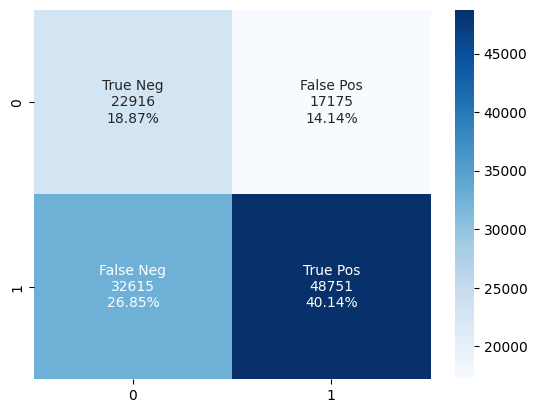

In [22]:
group_names = ["True Neg", "False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, fmt="", cmap='Blues', annot=labels)

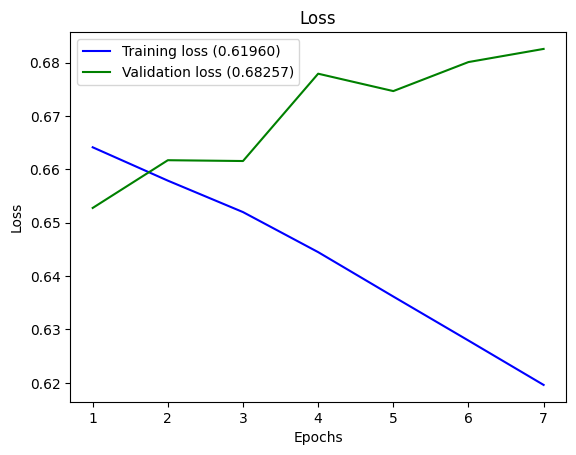

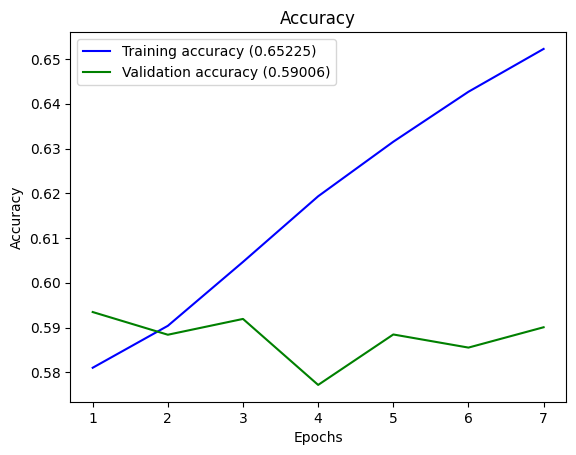

In [23]:
plot_history(model_history)